In [1]:
import umap
import torch
from torch.functional import F
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from common import h5dataset, model_dnn

c:\Users\sollb\Documents\fhnw\ip5\IP5-Jass-AI\training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)


In [ ]:
BATCH_SIZE = 256
NUM_ACTIONS = 9
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.99)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


# Load model
model_gan_untrained = model_dnn.ModelDNN(
    "JassPlayGenUntrained",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_gan_untrained.to(device)

model_gan = model_dnn.ModelDNN(
    "JassPlayGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_gan.load_state_dict(torch.load(os.path.join(MODLE_PATH, 'play_gan', 'JassGanGen_512_256_128_dnn.pth')))
model_gan.to(device)
model_gan.eval()
embedding_gan = model_gan.embedding



model_sl = model_dnn.ModelDNN(
    "JassPlaySL",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)

model_sl.load_state_dict(torch.load(os.path.join(MODLE_PATH, 'play', 'JassPlay_512_256_128_dnn.pth')))
model_sl.to(device)
model_sl.eval()


In [ ]:
# Containers
def create_state_action(model, loader):
    fake_combined = []
    real_combined = []
    with torch.no_grad():
        
        for state, action in tqdm(loader, desc=f"Creating vectors for {model.name}", unit="batch"):
            state, action = state.to(device), action.to(device)

            # Get action predictions
            logits = model(state)
            fake_actions = logits.argmax(dim=1)

            em_state =  (state)

            # remove history from state [0:31] and other hands [43:70]
            # stat is [32:42] and [71:71]
            em_state = torch.cat([em_state[:, 32:42], em_state[:, 71:72]], dim=1)
            # take the embedding of the action. it is n index in the embedded state
            em_fake_actions = em_state.gather(1, fake_actions.view(-1, 1).unsqueeze(-1).expand(-1, -1, em_state.size(2))).squeeze(1)
            em_real_actions = em_state.gather(1, action.view(-1, 1).unsqueeze(-1).expand(-1, -1, em_state.size(2))).squeeze(1)

            # flatten the state
            em_state = em_state.view(em_state.size(0), -1)

            # Combine input (state) with action vector
            fake_combined.append(torch.cat([em_state.cpu(), em_fake_actions.cpu()], dim=1))
            real_combined.append(torch.cat([em_state.cpu(), em_real_actions.cpu()], dim=1))

    fake_combined = torch.cat(fake_combined, dim=0)
    real_combined = torch.cat(real_combined, dim=0)

    return fake_combined.numpy(), real_combined.numpy()

labels = []
gan_fake, gan_real = create_state_action(model_gan, val_loader)
labels.extend(["gan_fake"] * len(gan_fake))
labels.extend(["gan_real"] * len(gan_real))

gan_untrained_fake, gan_untrained_real = create_state_action(model_gan_untrained, val_loader)
labels.extend(["gan_fake"] * len(gan_untrained_fake))
labels.extend(["gan_real"] * len(gan_untrained_real))



Creating vectors for JassPlaySL_512_256_128_dnn: 100%|██████████| 867/867 [00:05<00:00, 149.30batch/s]
Creating vectors for JassPlayGenUntrained_512_256_128_dnn: 100%|██████████| 867/867 [00:05<00:00, 148.09batch/s]


In [5]:
def reducer(vecs):
    umap.tqdm_progress = tqdm(total=vecs.shape[0], desc="UMAP embedding", unit="sample")
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, verbose=True, tqdm_kwds={'desc': 'UMAP fit', 'leave': True})
    embedding = reducer.fit_transform(vecs)
    return embedding

all_vecs_gan = np.vstack([gan_fake, gan_real])
all_vecs_untrained = np.vstack([gan_untrained_fake, gan_untrained_real])
embedding_gan = reducer(all_vecs_gan)
embedding_untrained = reducer(all_vecs_untrained)

UMAP embedding:   0%|          | 0/443706 [00:00<?, ?sample/s]

UMAP(n_neighbors=10, verbose=True)
Thu Jul 24 23:06:41 2025 Construct fuzzy simplicial set
Thu Jul 24 23:06:41 2025 Finding Nearest Neighbors
Thu Jul 24 23:06:41 2025 Building RP forest with 38 trees
Thu Jul 24 23:06:48 2025 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	Stopping threshold met -- exiting after 5 iterations
Thu Jul 24 23:06:59 2025 Finished Nearest Neighbor Search
Thu Jul 24 23:07:01 2025 Construct embedding


	completed  0  /  200 epochs


	completed  20  /  200 epochs


	completed  40  /  200 epochs


	completed  60  /  200 epochs


	completed  80  /  200 epochs


	completed  100  /  200 epochs


	completed  120  /  200 epochs


	completed  140  /  200 epochs


	completed  160  /  200 epochs


	completed  180  /  200 epochs


UMAP fit: 100%| ██████████ 200/200 [00:11]


Thu Jul 24 23:21:24 2025 Finished embedding


UMAP embedding:   0%|          | 0/443706 [14:45<?, ?sample/s]


UMAP(n_neighbors=10, verbose=True)
Thu Jul 24 23:21:26 2025 Construct fuzzy simplicial set
Thu Jul 24 23:21:26 2025 Finding Nearest Neighbors
Thu Jul 24 23:21:26 2025 Building RP forest with 38 trees
Thu Jul 24 23:21:31 2025 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	Stopping threshold met -- exiting after 5 iterations
Thu Jul 24 23:21:36 2025 Finished Nearest Neighbor Search
Thu Jul 24 23:21:37 2025 Construct embedding


UMAP fit:   2%| ▏          4/200 [00:00]

	completed  0  /  200 epochs


UMAP fit:  12%| █▏         23/200 [00:01]

	completed  20  /  200 epochs


UMAP fit:  22%| ██▏        43/200 [00:02]

	completed  40  /  200 epochs


UMAP fit:  32%| ███▏       63/200 [00:03]

	completed  60  /  200 epochs


UMAP fit:  42%| ████▏      83/200 [00:04]

	completed  80  /  200 epochs


UMAP fit:  52%| █████▏     103/200 [00:05]

	completed  100  /  200 epochs


UMAP fit:  62%| ██████▏    123/200 [00:06]

	completed  120  /  200 epochs


UMAP fit:  72%| ███████▏   143/200 [00:07]

	completed  140  /  200 epochs


UMAP fit:  82%| ████████▏  163/200 [00:09]

	completed  160  /  200 epochs


UMAP fit:  92%| █████████▏ 183/200 [00:10]

	completed  180  /  200 epochs


UMAP fit: 100%| ██████████ 200/200 [00:11]


Thu Jul 24 23:51:51 2025 Finished embedding


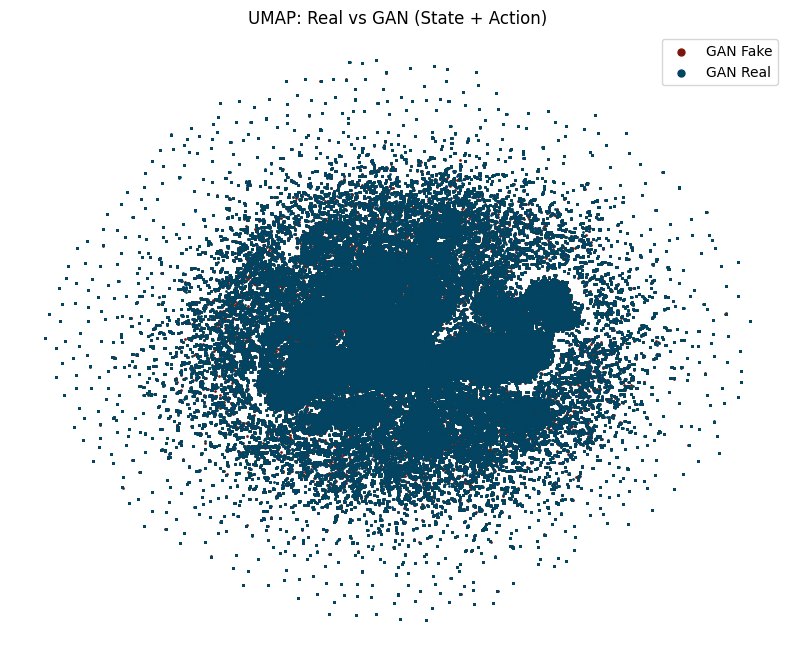

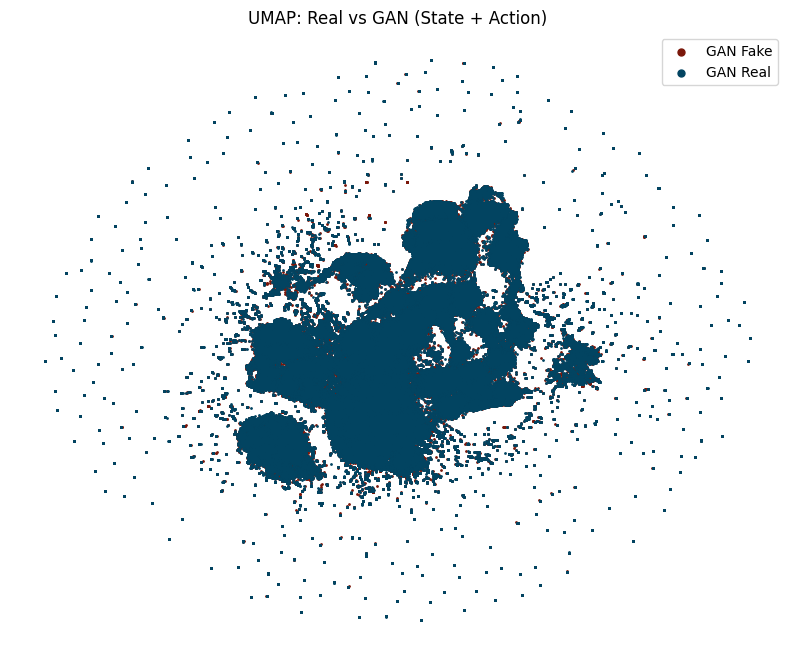

In [6]:
def plot_embedding(embedding, labels):
    # Define color mapping and readable labels
    label_to_color = {
        "gan_fake": "#7a170a",  # orange
        "gan_real": "#024461",  # light blue
    }

    # Create boolean masks
    gan_fake_mask = np.array(labels) == "gan_fake"
    gan_real_mask = np.array(labels) == "gan_real"

    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Create scatter plots and keep the handles
    sc1 = ax.scatter(
        embedding[gan_fake_mask, 0],
        embedding[gan_fake_mask, 1],
        c=label_to_color["gan_fake"],
        s=1,
        alpha=1,
        label="GAN Fake"
    )
    sc2 = ax.scatter(
        embedding[gan_real_mask, 0],
        embedding[gan_real_mask, 1],
        c=label_to_color["gan_real"],
        s=1,
        alpha=1,
        label="GAN Real"
    )

    # Now create the legend with custom marker size
    legend = ax.legend(
        handles=[sc1, sc2],
        labels=["GAN Fake", "GAN Real"],
        loc="best",
        fontsize=10,
        scatterpoints=1,
        markerscale=5  # Scale scatter marker size in legend
    )

    # Clean up axes and background
    for spine in ax.spines.values():
        spine.set_color('white')
    plt.xticks([])
    plt.yticks([])
    plt.title("UMAP: Real vs GAN (State + Action)")

    plt.show()

labels = []
labels.extend(["gan_fake"] * len(gan_fake))
labels.extend(["gan_real"] * len(gan_real))

plot_embedding(embedding_gan, labels)
plot_embedding(embedding_untrained, labels)
